In [28]:
import numpy as np
from scipy.spatial import cKDTree
import numba
from numba import prange


def vicsek_simulation_ckdtree_vectorized_numba(
    N=300, L=7.0, r=1.0, eta=0.2, v=0.03, 
    steps=500, dt=1.0, store_trajectories=True
):
    positions = np.random.uniform(0, L, (N, 2))
    directions = np.random.uniform(0, 2*np.pi, N)
    
    if store_trajectories:
        all_positions = np.empty((steps+1, N, 2), dtype=np.float32)
        all_directions = np.empty((steps+1, N), dtype=np.float32)
        all_positions[0] = positions
        all_directions[0] = directions
    else:
        all_positions, all_directions = None, None
    
    for step in range(steps):
        # Budowa drzewa (uwzględniamy warunki periodyczne)
        tree = cKDTree(positions, boxsize=L)
        
        # Szukamy sąsiadów w promieniu r dla wszystkich cząstek
        neighbors_list = tree.query_ball_point(positions, r)
        
        # Jeśli chcesz mieć pewność, że każda cząstka znajduje się w swojej liście,
        # odkomentuj poniższą linijkę:
        # neighbors_list = [nbrs if i in nbrs else nbrs + [i] for i, nbrs in enumerate(neighbors_list)]
        
        # Określamy maksymalną liczbę sąsiadów
        max_neighbors = max(len(nbrs) for nbrs in neighbors_list)
        
        # Budujemy macierz indeksów sąsiadów (wypełnioną wartością -1 tam, gdzie brak danych)
        neighbor_array = np.array([
            np.pad(nbrs, (0, max_neighbors - len(nbrs)), constant_values=-1)
            for nbrs in neighbors_list
        ], dtype=np.int32)
        
        # Maska – True tam, gdzie indeks jest prawidłowy (różny od -1)
        valid_mask = (neighbor_array != -1)
        
        # Obliczamy sin i cos dla wszystkich kierunków
        sin_vals = np.sin(directions)
        cos_vals = np.cos(directions)
        
        # Pobieramy wartości sin/cos dla sąsiadów; dzięki trybowi 'clip'
        # indeksy ujemne (czyli -1) są zamieniane na 0, a następnie zerujemy je maską
        sin_neighbors = np.take(sin_vals, neighbor_array, mode='clip') * valid_mask
        cos_neighbors = np.take(cos_vals, neighbor_array, mode='clip') * valid_mask
        
        # Sumujemy sin i cos dla sąsiadów każdej cząstki
        sum_sin = sin_neighbors.sum(axis=1)
        sum_cos = cos_neighbors.sum(axis=1)
        
        # Liczba sąsiadów (zawsze >= 1, bo self należy do sąsiadów)
        count_neighbors = valid_mask.sum(axis=1)
        # Unikamy dzielenia przez zero (choć w modelu Vicseka self zawsze jest obecny)
        count_neighbors[count_neighbors == 0] = 1
        
        # Średnia wartość sin i cos
        avg_sin = sum_sin / count_neighbors
        avg_cos = sum_cos / count_neighbors
        
        # Nowy kąt – arctan2 ze średnich + szum jednostajny w przedziale [-eta/2, eta/2]
        noise = eta * (np.random.rand(N) - 0.5)
        new_directions = np.arctan2(avg_sin, avg_cos) + noise
        new_directions %= (2*np.pi)
        
        # Aktualizacja pozycji (periodycznie)
        positions[:, 0] += v * np.cos(new_directions) * dt
        positions[:, 1] += v * np.sin(new_directions) * dt
        positions %= L
        
        # Aktualizacja kątów
        directions = new_directions
        
        # Zapis trajektorii, jeśli wymagane
        if store_trajectories:
            all_positions[step+1] = positions
            all_directions[step+1] = directions
    
    return all_positions, all_directions


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker

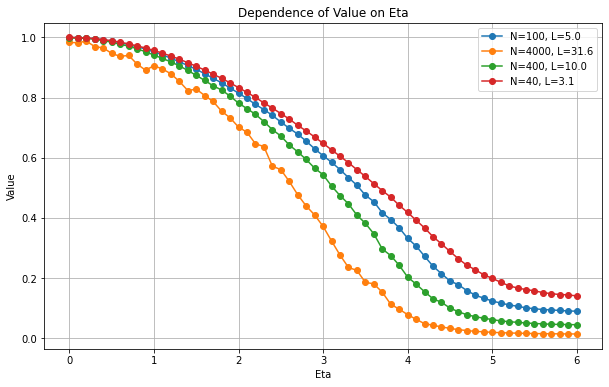

In [2]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Pobranie listy plików w bieżącym katalogu
folder_path = "./results_plot1"  # Możesz zmienić ścieżkę na odpowiednią
files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Słownik do przechowywania danych
data = {}

pattern = re.compile(r"va_mean_N(?P<N>\d+)_L(?P<L>[\d\.]+)_eta(?P<eta1>\d+)_(?P<eta2>\d+)\.npy")

for file in files:
    match = pattern.match(file)
    if match:
        #print(f"Matched: {file}")
        N = int(match.group("N"))
        L = float(match.group("L"))
        eta = float(f"{match.group('eta1')}.{match.group('eta2')}")  # Łączenie eta1 i eta2
        
        value = np.load(os.path.join(folder_path, file))
        key = (N, L)
        if key not in data:
            data[key] = []
        data[key].append((eta, value))

# Rysowanie wykresów
def plot_data(data):
    va_eta = {}
    plt.figure(figsize=(10, 6))
    for (N, L), values in data.items():
        values.sort()  # Sortujemy po eta
        etas, results = zip(*values)
        plt.plot(etas, results, marker='o', label=f'N={N}, L={L}')
        va_eta[N] = results
    plt.xlabel('Eta')
    plt.ylabel('Value')
    plt.title('Dependence of Value on Eta')
    plt.legend()
    plt.grid()
    plt.show()
    return va_eta

va_eta = plot_data(data)


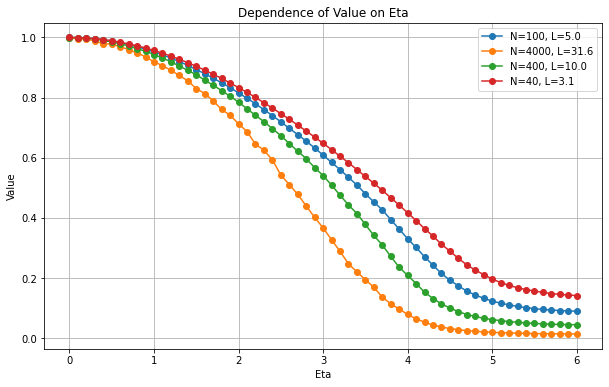

In [2]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Pobranie listy plików w bieżącym katalogu
folder_path = "./10_5/results_plot1"  # Możesz zmienić ścieżkę na odpowiednią
files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Słownik do przechowywania danych
data = {}

pattern = re.compile(r"va_mean_N(?P<N>\d+)_L(?P<L>[\d\.]+)_eta(?P<eta1>\d+)_(?P<eta2>\d+)\.npy")

for file in files:
    match = pattern.match(file)
    if match:
        #print(f"Matched: {file}")
        N = int(match.group("N"))
        L = float(match.group("L"))
        eta = float(f"{match.group('eta1')}.{match.group('eta2')}")  # Łączenie eta1 i eta2
        
        value = np.load(os.path.join(folder_path, file))
        key = (N, L)
        if key not in data:
            data[key] = []
        data[key].append((eta, value))

# Rysowanie wykresów
def plot_data(data):
    va_eta = {}
    plt.figure(figsize=(10, 6))
    for (N, L), values in data.items():
        values.sort()  # Sortujemy po eta
        etas, results = zip(*values)
        plt.plot(etas, results, marker='o', label=f'N={N}, L={L}')
        va_eta[N] = results
    plt.xlabel('Eta')
    plt.ylabel('Value')
    plt.title('Dependence of Value on Eta')
    plt.legend()
    plt.grid()
    plt.show()
    return va_eta

va_eta = plot_data(data)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Znalezione pliki: ['va_mean_N1000_L20_eta2_00.npy', 'va_mean_N1040_L20_eta2_00.npy', 'va_mean_N1080_L20_eta2_00.npy', 'va_mean_N1120_L20_eta2_00.npy', 'va_mean_N1160_L20_eta2_00.npy', 'va_mean_N1200_L20_eta2_00.npy', 'va_mean_N120_L20_eta2_00.npy', 'va_mean_N1240_L20_eta2_00.npy', 'va_mean_N1280_L20_eta2_00.npy', 'va_mean_N1320_L20_eta2_00.npy', 'va_mean_N1360_L20_eta2_00.npy', 'va_mean_N1400_L20_eta2_00.npy', 'va_mean_N1440_L20_eta2_00.npy', 'va_mean_N1480_L20_eta2_00.npy', 'va_mean_N1520_L20_eta2_00.npy', 'va_mean_N1560_L20_eta2_00.npy', 'va_mean_N1600_L20_eta2_00.npy', 'va_mean_N160_L20_eta2_00.npy', 'va_mean_N1640_L20_eta2_00.npy', 'va_mean_N1680_L20_eta2_00.npy', 'va_mean_N1720_L20_eta2_00.npy', 'va_mean_N1760_L20_eta2_00.npy', 'va_mean_N1800_L20_eta2_00.npy', 'va_mean_N1840_L20_eta2_00.npy', 'va_mean_N1880_L20_eta2_00.npy', 'va_mean_N1920_L20_eta2_00.npy', 'va_mean_N1960_L20_eta2_00.npy', 'va_mean_N2000_L20_eta2_00.npy', 'va_mean_N200_L20_eta2_00.npy', 'va_mean_N2040_L20_eta2_00.

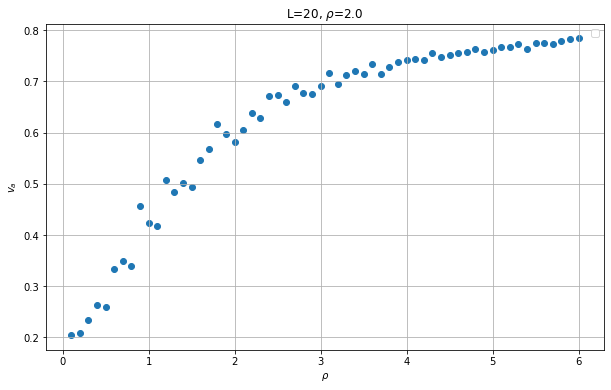

In [3]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Ścieżka do katalogu z plikami
folder_path = "results_plot2_rho_0_6_01"  # Zmień na właściwą ścieżkę

# Pobranie listy plików w katalogu
files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]
print(f"Znalezione pliki: {files}")

# Słownik do przechowywania danych
data = {}

# Poprawione wyrażenie regularne dla nowego formatu
pattern = re.compile(r"va_mean_N(?P<N>\d+)_L(?P<L>[\d\.]+)_eta(?P<eta1>\d+)_(?P<eta2>\d+)\.npy")

# Lista do przechowywania danych
data_list = []

for file in files:
    match = pattern.match(file)
    if match:
        print(f"✅ Pasuje: {file}")  # Sprawdzenie, które pliki pasują
        N = int(match.group("N"))
        L = float(match.group("L"))
        eta = float(f"{match.group('eta1')}.{match.group('eta2')}")  # Łączenie eta1 i eta2

        value = np.load(os.path.join(folder_path, file))
        print(f"📥 Załadowano plik {file} z wartością {value}")

        data_list.append((N, L, eta, value))
    else:
        print(f"❌ Nie pasuje: {file}")

# Sortowanie listy po wartości N
data_list.sort(key=lambda x: x[0])

# Rysowanie wykresów
def plot_data(data_list):
    plt.figure(figsize=(10, 6))
    Ns, _, etas, values = zip(*data_list)
    
    plt.scatter(np.arange(0.1, 6.1, .1), values, marker='o')
    
    plt.xlabel('$\\rho$')
    plt.ylabel('$v_a$')
    plt.title('L=20, $\\rho$=2.0')
    plt.legend()
    plt.grid()
    plt.show()
    return values



values = plot_data(data_list)


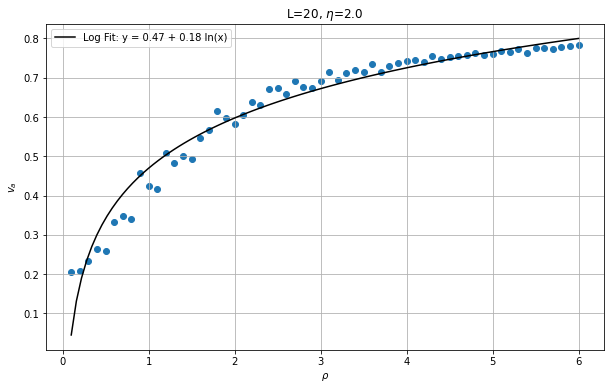

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample data (replace this with your actual data)
x_data = np.arange(0.1, 6.1, .1)
y_data = values

# Define logarithmic function
def log_func(x, a, b):
    return  a + b * np.log(x)
# def log_func(x, b):
#     return b * np.log(x)
# Fit the curve
params, covariance = curve_fit(log_func, x_data, y_data)

# Extract parameters
a_fit, b_fit = params
# b_fit = params[0]
# Generate fitted values
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = log_func(x_fit, a_fit, b_fit)
# y_fit = log_func(x_fit, b_fit)


plt.figure(figsize=(10, 6))
plt.scatter( np.arange(0.1, 6.1, .1), values)
plt.plot(x_fit, y_fit, label=f"Log Fit: y = {a_fit:.2f} + {b_fit:.2f} ln(x)", color='k')
# plt.plot(x_fit, y_fit, label=f"Log Fit: y = {b_fit:.2f} ln(x)", color='k')
plt.xlabel('$\\rho$')
plt.ylabel('$v_a$')
plt.title('L=20, $\\eta$=2.0')
plt.legend()
plt.grid()
plt.show()


In [6]:
for k in va_eta.keys():
    va_eta[k] = np.array(va_eta[k])

Szacowane eta_c(L): {40: 3.6600384290513315, 100: 3.426527592236595, 400: 3.1220879926328253, 4000: 2.6622089504708946}
Szacowane rho_c(L=20): 0.9493556321855967
L=40: slope (beta) ~ 0.207
L=100: slope (beta) ~ 0.184
L=400: slope (beta) ~ 0.179
L=4000: slope (beta) ~ 0.200


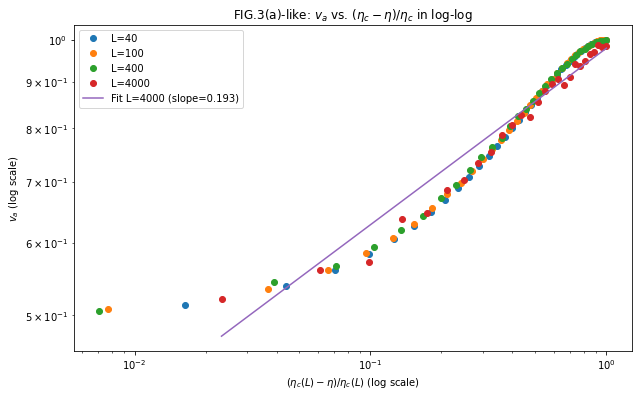

rho slope (delta) ~ 0.163


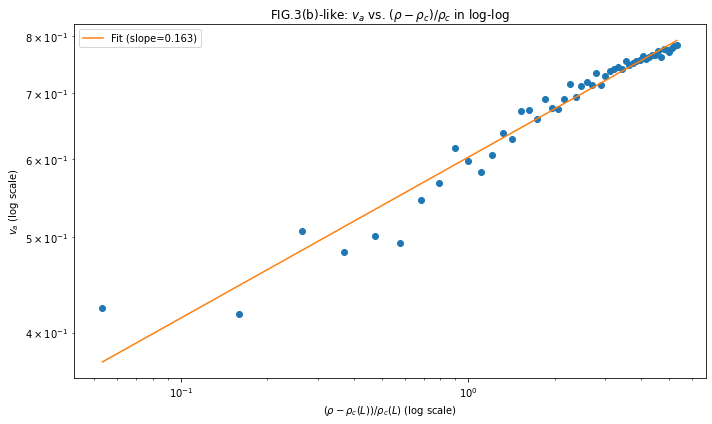

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import log

##############################
# 1) PRZYKŁAD DANYCH (fikcyjne!)
##############################

# Załóżmy, że z poprzednich symulacji masz tablice:
# v_a(eta) dla różnych L (przy stałej gęstości ρ=4),
#   -> eta_values_all[L] : tablica et
#   -> va_eta_all[L]     : tablica v_a(eta)
# oraz v_a(rho) dla L=20, eta=2
#   -> rho_values : tablica rho
#   -> va_rho     : tablica v_a(rho)
#
# Wstaw tutaj swoje realne wyniki; poniżej są "zastępniki"

eta_values_all = {
    40:  np.arange(0.0, 6.1, 0.1),
    100: np.arange(0.0, 6.1, 0.1),
    400: np.arange(0.0, 6.1, 0.1),
    4000: np.arange(0.0, 6.1, 0.1),
}
va_eta_all = va_eta

# Teraz dane v_a(rho) dla L=20, eta=2 (przykładowe, też fikcyjne):
rho_values = np.arange(0.1, 6.1, 0.1)
va_rho     = np.array(values)


##############################
# 2) WYZNACZANIE ETA_C(L) i RHO_C(L) - przykładowa metoda
##############################

def find_critical_via_halfmax(x_vals, va_vals):
    """
    Metoda 'połowy maksymalnej wartości'.
    Znajduje x_c, przy którym v_a spada do 0.5 * max(v_a).
    (Zakładamy, że v_a monotonicznie spada z rosnącym x.)
    """
    va_max = va_vals.max()
    half = 0.5 * va_max

    # sortujemy dane po x:
    idx_sort = np.argsort(x_vals)
    x_sorted = x_vals[idx_sort]
    va_sorted = va_vals[idx_sort]

    # tworzymy interpolację odwrotną: va -> x
    f = interp1d(va_sorted, x_sorted, kind='linear', bounds_error=False,
                 fill_value="extrapolate")

    x_c = float(f(half))
    return x_c

##############################
# 3) WYZNACZENIE ETA_C(L) i RHO_C(L)
##############################
eta_c_dict = {}
for L, etas in eta_values_all.items():
    va_vals = va_eta_all[L]
    # Tu jest fikcyjna metoda half-max:
    eta_c_est = find_critical_via_halfmax(etas, va_vals)
    eta_c_dict[L] = eta_c_est

# Przykład wyznaczenia rho_c(20)
rho_c_est = find_critical_via_halfmax(rho_values, va_rho)

print("Szacowane eta_c(L):", eta_c_dict)
print("Szacowane rho_c(L=20):", rho_c_est)

##############################
# 4) FIG.3(a): v_a vs ( (eta_c(L) - eta) / eta_c(L) ) w SKALI LOG-LOG
##############################
plt.figure(figsize=(10,6))
slopes_c = []
slopes_m = []
# plt.subplot(1,2,1)
for L, etas in eta_values_all.items():
    va_vals = va_eta_all[L]

    # 1) weź naszą "eta_c(L)"
    e_c = eta_c_dict[L]

    # 2) weź tylko te punkty, gdzie eta < eta_c(L) i v_a>0
    mask = (etas < e_c) & (va_vals>0)
    x_ = (e_c - etas[mask]) / e_c  # to jest (eta_c - eta)/eta_c
    y_ = va_vals[mask]

    # 3) odrzuć ewentualne <=0
    mask2 = (x_>0) & (y_>0)
    x_ = x_[mask2]
    y_ = y_[mask2]

    # 4) rysowanie w SKALI LOG-LOG
    #   -> zamiast plot(log(x), log(y)) i osi liniowych
    #   -> robimy po prostu:
    plt.loglog(x_, y_, 'o', label=f'L={L}')

    # 5) dopasowanie prostej w log-log
    #    log y = m * log x + c
    logx = np.log(x_)
    logy = np.log(y_)

    # aby "złapać" fragment, gdzie dane są ~liniowe, często ogranicza się do 
    # x_ bliskich 0 < x < 0.3 np. (to zależy)
    # Tu dla przykładu bierzemy je wszystkie.
    
    if len(logx) >= 2:
        A = np.vstack([logx, np.ones(len(logx))]).T
        m, c = np.linalg.lstsq(A, logy, rcond=None)[0]
        # m to slope ~ beta
        print(f"L={L}: slope (beta) ~ {m:.3f}")
        slopes_m.append(m)
        slopes_c.append(c)
c = np.mean(slopes_c)
m = np.mean(slopes_m)
x_fit = np.linspace(np.min(x_), np.max(x_), 100)
y_fit = np.exp(c) * x_fit**m
plt.loglog(x_fit, y_fit, '-', label=f'Fit L={L} (slope={m:.3f})')

plt.xlabel(r"$(\eta_c(L) - \eta)/\eta_c(L)$ (log scale)")
plt.ylabel(r"$v_a$ (log scale)")
plt.title("FIG.3(a)-like: $v_a$ vs. $(\eta_c - \eta)/\eta_c$ in log-log")
plt.legend()
# ax1 = plt.gca()
# ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
# ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{y:.2f}"))

# plt.grid(True)
plt.show()
##############################
# 5) FIG.3(b): v_a vs ( (rho - rho_c(L)) / rho_c(L) ) w SKALI LOG-LOG
##############################
# plt.subplot(1,2,2)

plt.figure(figsize=(10,6))
rc = rho_c_est
# Mamy (rho_values, va_rho) -> z L=20, eta=2

maskr = (rho_values > rc) & (va_rho>0)
x_rho = (rho_values[maskr] - rc)/rc
y_rho = va_rho[maskr]

# Odrzucamy x<=0
maskr2 = (x_rho>0)
x_rho = x_rho[maskr2]
y_rho = y_rho[maskr2]

# rysujemy w skali log-log
plt.loglog(x_rho, y_rho, 'o')

# dopasowanie prostej
if len(x_rho)>=2:
    logx_rho = np.log(x_rho)
    logy_rho = np.log(y_rho)
    A2 = np.vstack([logx_rho, np.ones(len(logx_rho))]).T
    m2, c2 = np.linalg.lstsq(A2, logy_rho, rcond=None)[0]
    print(f"rho slope (delta) ~ {m2:.3f}")
    x_fit_rho = np.linspace(np.min(x_rho), np.max(x_rho), 100)
    y_fit_rho = np.exp(c2) * x_fit_rho**m2
    plt.loglog(x_fit_rho, y_fit_rho, '-', label=f'Fit (slope={m2:.3f})')

plt.xlabel(r"$(\rho - \rho_c(L))/\rho_c(L)$ (log scale)")
plt.ylabel(r"$v_a$ (log scale)")
plt.title("FIG.3(b)-like: $v_a$ vs. $(\\rho - \\rho_c)/\\rho_c$ in log-log")
# plt.grid(True)
plt.legend()
# ax2 = plt.gca()
# ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
# ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{y:.2f}"))

plt.tight_layout()
plt.show()


# Obstackles

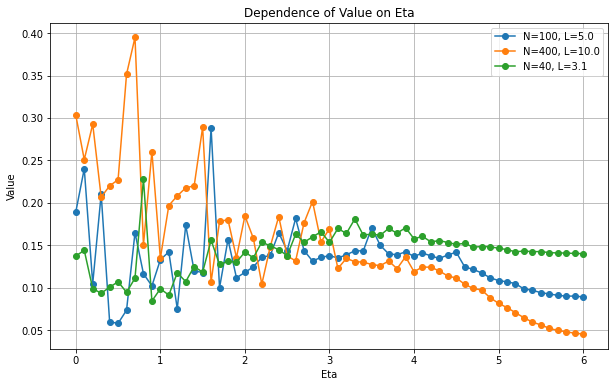

In [1]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Pobranie listy plików w bieżącym katalogu
folder_path = "./results_plot1_obs"  # Możesz zmienić ścieżkę na odpowiednią
files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Słownik do przechowywania danych
data = {}

pattern = re.compile(r"va_mean_N(?P<N>\d+)_L(?P<L>[\d\.]+)_eta(?P<eta1>\d+)_(?P<eta2>\d+)\.npy")

for file in files:
    match = pattern.match(file)
    if match:
        #print(f"Matched: {file}")
        N = int(match.group("N"))
        L = float(match.group("L"))
        eta = float(f"{match.group('eta1')}.{match.group('eta2')}")  # Łączenie eta1 i eta2
        
        value = np.load(os.path.join(folder_path, file))
        key = (N, L)
        if key not in data:
            data[key] = []
        data[key].append((eta, value))

# Rysowanie wykresów
def plot_data(data):
    va_eta = {}
    plt.figure(figsize=(10, 6))
    for (N, L), values in data.items():
        values.sort()  # Sortujemy po eta
        etas, results = zip(*values)
        plt.plot(etas, results, marker='o', label=f'N={N}, L={L}')
        va_eta[N] = results
    plt.xlabel('Eta')
    plt.ylabel('Value')
    plt.title('Dependence of Value on Eta')
    plt.legend()
    plt.grid()
    plt.show()
    return va_eta

va_eta = plot_data(data)


The Vicsek model, introduced by Tamas Vicsek in 1995, is one of the fundamental models in the study of collision motion and collective behavior. The model simulates the motion of agents (particles) in a two-dimensional space, where each agent moves at a certain speed, adjusting its direction of motion based on the behavior of its neighbors. Vicesek's model is crucial in understanding such phenomena as the formation of swarms, flocks and other structures in nature.

**Parameters**
- N: Number of particles (agents).
- L: Size of the simulation space (L x L square).
- r: Neighborhood radius.
- eta $\eta$: Noise amplitude (range of random directional interference).
- v: Constant velocity.
- steps: Number of simulation time steps.
- dt: Time step length.
- store_trajectories: save positions after each step for simulation purposes.

In [63]:
result_50.shape

(1000, 100, 2)

In [64]:
import numpy as np
from scipy.spatial import cKDTree

def vicsek_simulation_ckdtree_vectorized(
    N=300, L=7.0, r=1.0, eta=0.2, v=0.03, 
    steps=500, dt=1.0, store_trajectories=True
):
    # --- Inicjalizacja ---
    positions = np.random.uniform(0, L, (N, 2))     # (N,2) położenia
    directions = np.random.uniform(0, 2*np.pi, N)   # (N,) kierunki w [0,2π)
    
    if store_trajectories:
        # Zapis w tablicach (steps+1) x N x 2 i (steps+1) x N
        # albo w listach - tutaj tablice:
        all_positions = np.empty((steps+1, N, 2), dtype=np.float32)
        all_directions = np.empty((steps+1, N), dtype=np.float32)
        all_positions[0] = positions
        all_directions[0] = directions
    else:
        all_positions = None
        all_directions = None
    
    # --- Główna pętla czasowa ---
    for step in range(steps):
        # 1) Budowa cKDTree (uwzględnia warunki periodyczne przez boxsize=L)
        tree = cKDTree(positions, boxsize=L)
        
        # 2) Lista list sąsiadów
        #    query_ball_point zwraca listę z N elementami; element i to lista sąsiadów i-tej cząstki
        neighbors_list = tree.query_ball_point(positions, r)
        
        # 2a) Opcjonalnie włączamy cząstkę samą w sobie (tak jak w oryginalnym Vicseku)
        neighbors_list = [nbrs if i in nbrs else nbrs + [i] for i, nbrs in enumerate(neighbors_list)]
        
        # 2b) Określamy, ile maksymalnie sąsiadów występuje
        max_neighbors = max(len(nbrs) for nbrs in neighbors_list)
        
        # 2c) Tworzymy 2D tablicę o wymiarze (N, max_neighbors), wypełnioną -1
        neighbor_array = np.full((N, max_neighbors), -1)
        
        # 2d) Wypełniamy neighbor_array indeksami sąsiadów
        for i, nbrs in enumerate(neighbors_list):
            neighbor_array[i, :len(nbrs)] = nbrs
        # neighbor_array[:, :max_neighbors] = [n + [-1] * (max_neighbors - len(n)) for n in neighbors_list]  # Wypełnianie tablicy

        
        # 3) Wektorowo liczymy sumy sin i cos
        sin_dir = np.sin(directions)
        cos_dir = np.cos(directions)
        
        # Maska True/False = czy dany "slot" w neighbor_array jest obsadzony
        valid_mask = (neighbor_array != -1)  # shape (N, max_neighbors)
        
        # sin_dir[neighbor_array] - to shape (N, max_neighbors), ale -1 jest niepoprawnym indeksem.
        # Dlatego mnożymy przez valid_mask, by wyzerować wkład z -1.
        sum_sin = np.sum( sin_dir[neighbor_array] * valid_mask, axis=1 )
        sum_cos = np.sum( cos_dir[neighbor_array] * valid_mask, axis=1 )
        
        # Liczba sąsiadów
        count_neighbors = valid_mask.sum(axis=1)
        
        # Unikamy dzielenia przez zero (w modelu Vicseka z self in neighbors i tak count>=1)
        # Niemniej warto się zabezpieczyć:
        count_neighbors = np.where(count_neighbors==0, 1, count_neighbors)
        
        # Średnie sin i cos
        avg_sin = sum_sin / count_neighbors
        avg_cos = sum_cos / count_neighbors
        
        # Nowy kąt = arctan2(...) + noise
        # Noise w [-eta/2, +eta/2]
        noise = eta * (np.random.rand(N) - 0.5)
        
        new_directions = np.arctan2(avg_sin, avg_cos) + noise
        new_directions %= (2*np.pi)  # zawijamy w [0,2π)
        
        # 4) Aktualizacja położeń (wektorowo)
        positions[:,0] += v * np.cos(new_directions) * dt
        positions[:,1] += v * np.sin(new_directions) * dt
        positions %= L  # periodyczne warunki brzegowe
        
        # 5) Przepisujemy directions
        directions = new_directions
        
        # 6) Zapis do trajektorii, jeśli potrzebne
        if store_trajectories:
            all_positions[step+1] = positions
            all_directions[step+1] = directions
    
    return all_positions, all_directions


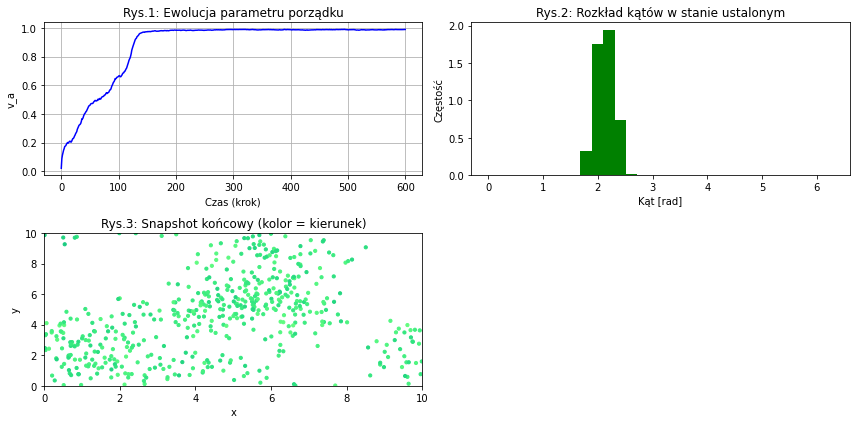

In [67]:
def measure_order_parameter(positions, directions):
    """
    v_a = 1/N * sqrt( (sum cosθ_i)^2 + (sum sinθ_i)^2 ).
    Zakładamy, że sumujemy po wektorach jednostkowych
    (czyli parametry prędkości v nie wchodzą do definicji).
    """
    N = len(directions)
    vx = np.cos(directions).sum()
    vy = np.sin(directions).sum()
    return np.sqrt(vx*vx + vy*vy) / N


N = 500
L = 10.0
r = 1.0
eta = 0.5
v = 0.05
steps = 600

all_positions, all_directions = vicsek_simulation_ckdtree_vectorized(
    N=N, L=L, r=r, eta=eta, v=v, steps=steps, store_trajectories=True
)

# all_positions.shape = (steps+1, N, 2)
# all_directions.shape = (steps+1, N)

# A) RYSUNEK 1: Czasowa ewolucja parametru porządku v_a
time_array = np.arange(steps+1)
va_array = []
for t in time_array:
    va_array.append(
        measure_order_parameter(all_positions[t], all_directions[t])
    )
va_array = np.array(va_array)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(time_array, va_array, 'b-')
plt.xlabel("Czas (krok)")
plt.ylabel("v_a")
plt.title("Rys.1: Ewolucja parametru porządku")
plt.grid(True)

# B) RYSUNEK 2: Histogram rozkładu kątów w stanie (prawie) ustalonym
#    Weźmy np. ostatnie 100 kroków, zbierzmy kierunki
last_steps = range(steps-100, steps+1)
all_thetas = all_directions[last_steps].ravel()  # spłaszczamy
plt.subplot(2,2,2)
plt.hist(all_thetas, bins=30, range=(0,2*np.pi), density=True, color='g')
plt.xlabel("Kąt [rad]")
plt.ylabel("Częstość")
plt.title("Rys.2: Rozkład kątów w stanie ustalonym")

# C) RYSUNEK 3: Snapshot końcowy – x-y, pokolorowany wg kierunku
final_positions = all_positions[-1]
final_directions = all_directions[-1]
plt.subplot(2,2,3)

# Kolor = (cosθ, sinθ, 0.5) -> widać gradient kierunków
colors = np.vstack([
    0.5*(1 + np.cos(final_directions)),
    0.5*(1 + np.sin(final_directions)),
    0.5*np.ones_like(final_directions),
]).T

plt.scatter(final_positions[:,0], final_positions[:,1], c=colors, s=10)
plt.xlim([0,L])
plt.ylim([0,L])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Rys.3: Snapshot końcowy (kolor = kierunek)")

# (Ew. dodać wektor porządku?)

plt.tight_layout()
plt.show()


plt.show()

In [ ]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

###################################
# 1) Funckje pomocnicze
###################################

def line_circle_intersect(x_old, x_new, cx, cy, R):
    """
    Znajduje przecięcie odcinka x_old -> x_new z okręgiem (cx, cy, R).
    x_old: (2,) stara pozycja
    x_new: (2,) nowa pozycja
    Zwraca (t, point), gdzie t w [0,1], point = (px, py) jest punktem przecięcia
    jeśli istnieje. Jeśli brak przecięcia lub leży poza odcinkiem [0,1], 
    zwraca (None, None).
    
    Rozwiązujemy || x_old + t*(x_new - x_old) - c || = R
    tj. || (dx, dy)*t + (x_old - c) || = R.
    """
    ox, oy = x_old
    nx, ny = x_new
    dx = nx - ox
    dy = ny - oy
    
    # Wektor do środka okręgu
    fx = ox - cx
    fy = oy - cy
    
    # Parametry równania kwadratowego
    # (dx^2 + dy^2)*t^2 + 2(dx fx + dy fy)*t + (fx^2 + fy^2 - R^2) = 0
    A = dx*dx + dy*dy
    B = 2*(dx*fx + dy*fy)
    C = fx*fx + fy*fy - R*R
    
    # Jeśli A=0 (x_old==x_new?), raczej brak ruchu
    if abs(A) < 1e-14:
        return None, None
    
    disc = B*B - 4*A*C
    if disc < 0:
        # brak rzeczywistego przecięcia
        return None, None
    
    # Mamy 2 rozwiązania t1, t2:
    sqrt_disc = np.sqrt(disc)
    t1 = (-B - sqrt_disc) / (2*A)
    t2 = (-B + sqrt_disc) / (2*A)
    
    # Szukamy "najmniejszego dodatniego" t, bo to pierwsze przecięcie z odcinkiem
    sol = []
    for tt in [t1, t2]:
        if 0 <= tt <= 1:
            sol.append(tt)
    
    if len(sol)==0:
        return None, None
    
    t_hit = min(sol)
    px = ox + t_hit*dx
    py = oy + t_hit*dy
    return t_hit, (px, py)

def reflect_direction(old_dir, normal_vec):
    """
    Odbicie wektora z kąta old_dir (radian) względem normal_vec (2,).
    normal_vec nie musi być znormalizowany, ważny jest kierunek.
    Zwraca new_dir (radian).
    
    Algorytm:
      v = (cos old_dir, sin old_dir)
      n = normal_vec (unorm)
      1) un = n / ||n||
      2) v' = v - 2(v dot un)*un
      3) new_dir = atan2(v'_y, v'_x)
    """
    vx = np.cos(old_dir)
    vy = np.sin(old_dir)
    nx, ny = normal_vec
    
    norm_n = np.sqrt(nx*nx + ny*ny)
    if norm_n < 1e-14:
        return old_dir  # normal degenerate => no reflection
    
    unx = nx / norm_n
    uny = ny / norm_n
    
    dot = vx*unx + vy*uny
    rx = vx - 2*dot*unx
    ry = vy - 2*dot*uny
    
    return np.arctan2(ry, rx)

def inside_any_obstacle(pos, obstacles):
    """
    Czy pos=(x,y) leży w środku którejś z przeszkód?
    """
    x, y = pos
    for cx, cy, R in obstacles:
        dx = x - cx
        dy = y - cy
        if dx*dx + dy*dy < R*R:
            return True
    return False

###################################
# 2) Vicsek z precyzyjnym odbiciem od okręgu
###################################

def vicsek_simulation_with_obstacle_reflect(
    N=300, L=10.0, r=1.0, eta=0.2, v=0.03,
    steps=500, dt=1.0, obstacles=None,
    store_trajectories=True
):
    """
    Modyfikacja modelu Vicseka:
     - cKDTree do sąsiadów,
     - Okolice przeszkód: jeśli tor od x_old do x_new przecina okrąg,
       to cząstka kończy ruch w punkcie przecięcia i odbija kierunek
       względem normalnej do okręgu.
     - Jeśli tor nie przecina, ale finał wypadł "wewnątrz" (skrajne),
       to stawiamy na brzegu w najbliższym punkcie i odbijamy.
    """
    if obstacles is None:
        obstacles = []
    
    positions = np.random.uniform(0, L, (N, 2))
    directions = np.random.uniform(0, 2*np.pi, (N,))
    
    if store_trajectories:
        all_positions = np.zeros((steps+1, N, 2), dtype=np.float32)
        all_directions = np.zeros((steps+1, N), dtype=np.float32)
        all_positions[0] = positions
        all_directions[0] = directions
    else:
        all_positions, all_directions = None, None
    
    for step in range(steps):
        # 1) cKDTree
        tree = cKDTree(positions, boxsize=L)
        neighbors_list = tree.query_ball_point(positions, r)
        
        # Self-inclusion (Vicsek standard)
        for i, nbrs in enumerate(neighbors_list):
            if i not in nbrs:
                nbrs.append(i)
        
        # 2) Średnie kąty + szum
        sin_dir = np.sin(directions)
        cos_dir = np.cos(directions)
        new_dirs = np.zeros_like(directions)
        
        for i, nbrs in enumerate(neighbors_list):
            sum_sin = np.sum(sin_dir[nbrs])
            sum_cos = np.sum(cos_dir[nbrs])
            ccount = len(nbrs)
            avg_sin = sum_sin / ccount
            avg_cos = sum_cos / ccount
            
            noise = eta*(np.random.random()-0.5)  # [-eta/2, +eta/2]
            angle = np.arctan2(avg_sin, avg_cos) + noise
            new_dirs[i] = angle % (2*np.pi)
        
        # 3) Aktualizujemy pozycje kandydujące
        old_positions = positions.copy()
        positions[:,0] += v*np.cos(new_dirs)*dt
        positions[:,1] += v*np.sin(new_dirs)*dt
        # Periodyczne brzegowe
        positions %= L
        
        # 4) Sprawdzamy kolizje z przeszkodami 
        #    (szukamy najmniejszego t, jesli kilka okręgów)
        for i in range(N):
            x_old = old_positions[i]
            x_new = positions[i]
            dir_old = new_dirs[i]
            
            # Krok A: sprawdzamy wszystkie przeszkody, 
            #         czy jest przecięcie w [0,1]?
            min_t = 2.0
            best_pt = None
            best_obs = None
            for (cx, cy, R) in obstacles:
                t_hit, p_hit = line_circle_intersect(x_old, x_new, cx, cy, R)
                if t_hit is not None and t_hit<min_t:
                    min_t = t_hit
                    best_pt = p_hit
                    best_obs = (cx, cy, R)
            
            # Jeśli min_t <=1 => mamy kolizję "w trakcie" ruchu
            if min_t <=1.0 and best_pt is not None:
                # Wstawiamy w punkt kolizji
                positions[i] = best_pt
                # Odbijamy kierunek
                cx, cy, R = best_obs
                nx = best_pt[0] - cx
                ny = best_pt[1] - cy
                new_dirs[i] = reflect_direction(dir_old, (nx, ny))
                
            else:
                # Krok B: sprawdź, czy finał nie jest jednak w środku
                if inside_any_obstacle(positions[i], obstacles):
                    # Wtedy stawiamy na brzegu w najbliższym punkcie 
                    # i odbijamy w stronę normalną
                    # (co oznacza, że wniknęliśmy - 
                    #  to nieco bardziej "agresywne" wniknięcie, 
                    #  więc może się rzadko zdarzać)
                    # 
                    # Znajdujemy obstacle, do którego wpadł 
                    # (tu upraszczamy, że jest tylko jeden).
                    for (cx, cy, R) in obstacles:
                        dx = positions[i,0]-cx
                        dy = positions[i,1]-cy
                        dist = np.hypot(dx,dy)
                        if dist < R:
                            # stawiamy na brzegu 
                            ratio = R/dist
                            bx = cx + dx*ratio
                            by = cy + dy*ratio
                            positions[i,0]=bx
                            positions[i,1]=by
                            # normalna 
                            new_dirs[i] = reflect_direction(
                                new_dirs[i], (dx,dy)
                            )
                            break
        
        # 5) Zatwierdzamy kierunki
        directions = new_dirs
        
        # 6) Zapis
        if store_trajectories:
            all_positions[step+1] = positions
            all_directions[step+1] = directions
    
    return all_positions, all_directions


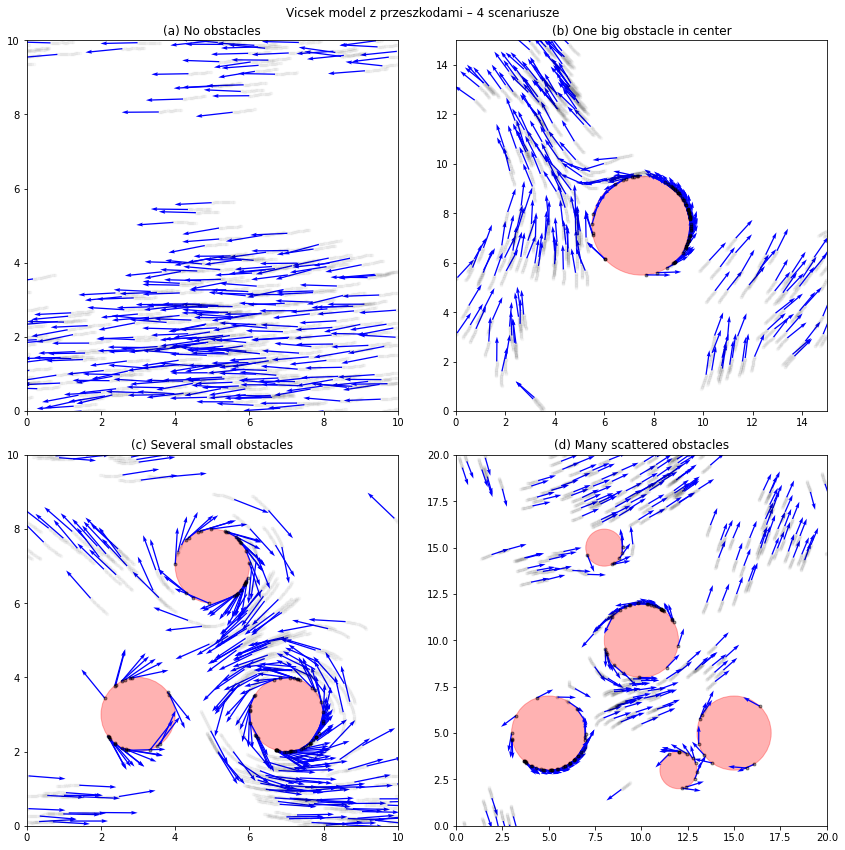

In [71]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

#####################################
# 1) Definicja przeszkód i sprawdzanie kolizji
#####################################

def inside_any_obstacle(pos, obstacles):
    """
    Sprawdza, czy punkt pos = (x, y) znajduje się
    wewnątrz którejś z okrągłych przeszkód.
    
    obstacles - lista krotek (cx, cy, r), gdzie (cx, cy) to środek przeszkody,
                a r to jej promień.
    Zwraca True jeśli tak, False w p.p.
    """
    x, y = pos
    for (cx, cy, rr) in obstacles:
        dx = x - cx
        dy = y - cy
        if dx*dx + dy*dy < rr*rr:
            return True
    return False

#####################################
# 2) Modyfikacja Vicseka - z przeszkodami
#####################################

def vicsek_simulation_with_obstacles(
    N=300, L=10.0, r=1.0, eta=0.2, v=0.03,
    steps=500, dt=1.0, obstacles=None,
    store_trajectories=True
):
    """
    Model Vicseka z przeszkodami (okrągłymi).
    - Każda przeszkoda: (cx, cy, R).
    - Gdy nowa pozycja wypadnie w obszarze przeszkody,
      cząstka 'odbija' (kierunek -> lustrzane odbicie),
      i pozycja zostaje cofnięta do poprzedniej dozwolonej.
    """
    if obstacles is None:
        obstacles = []  # brak przeszkód domyślnie
    
    # Losowa inicjalizacja
    positions = np.random.uniform(0, L, (N, 2))
    directions = np.random.uniform(0, 2*np.pi, (N,))
    
    if store_trajectories:
        all_positions = np.zeros((steps+1, N, 2), dtype=np.float32)
        all_directions = np.zeros((steps+1, N), dtype=np.float32)
        all_positions[0] = positions
        all_directions[0] = directions
    else:
        all_positions, all_directions = None, None
    
    for step in range(steps):
        # 1) Budujemy cKDTree z parametrem boxsize=L (warunki periodyczne)
        tree = cKDTree(positions, boxsize=L)
        
        # 2) Dla każdej cząstki wyszukujemy sąsiadów w promieniu r
        neighbors_list = tree.query_ball_point(positions, r)
        
        # Upewniamy się, że cząstka liczy sama siebie (standard Vicsek)
        for i, nbrs in enumerate(neighbors_list):
            if i not in nbrs:
                nbrs.append(i)
        
        # 3) Obliczamy nowe kierunki
        sin_dir = np.sin(directions)
        cos_dir = np.cos(directions)
        
        new_directions = np.zeros_like(directions)
        
        for i, nbrs in enumerate(neighbors_list):
            sum_sin = np.sum(sin_dir[nbrs])
            sum_cos = np.sum(cos_dir[nbrs])
            count = len(nbrs)
            
            avg_sin = sum_sin / count
            avg_cos = sum_cos / count
            
            noise = eta * (np.random.random() - 0.5)  # [-eta/2, +eta/2]
            new_angle = np.arctan2(avg_sin, avg_cos) + noise
            new_directions[i] = new_angle % (2*np.pi)
        
        # 4) Aktualizujemy pozycje kandydackie (z warunkami brzegowymi)
        #    a potem sprawdzamy kolizje z przeszkodami
        new_positions = positions.copy()
        new_positions[:,0] += v * np.cos(new_directions) * dt
        new_positions[:,1] += v * np.sin(new_directions) * dt
        
        # Periodyczne warunki brzegowe
        new_positions %= L
        
        # 5) Sprawdzamy, które cząstki trafiły w przeszkodę i je 'odbijamy'
        for i in range(N):
            if inside_any_obstacle(new_positions[i], obstacles):
                # "Odbicie" – prosty model lustrzany:
                #     theta -> theta + pi
                #     a pozycja zostaje przy starej
                new_directions[i] = (new_directions[i] + np.pi) % (2*np.pi)
                new_positions[i] = positions[i]  # cofnij do starej pozycji
        
        # 6) Zatwierdzamy nowe positions i directions
        positions = new_positions
        directions = new_directions
        
        # 7) Zapisujemy trajektorie
        if store_trajectories:
            all_positions[step+1] = positions
            all_directions[step+1] = directions
    
    return all_positions, all_directions

#####################################
# 3) Przykładowa wizualizacja (4 scenariusze)
#####################################

def plot_fig_obstacle_scenarios():
    """
    Cztery scenariusze z przeszkodami (okrągłymi) + standard Vicsek:
      a) Brak przeszkód
      b) Jedna duża przeszkoda pośrodku
      c) Kilka mniejszych przeszkód
      d) Duży L, mnóstwo drobnych przeszkód
    """
    import math
    
    # Lista scenariuszy
    scenarios = [
        dict(L=10, eta=0.3, desc="(a) No obstacles", 
             obstacles=None),
        
        dict(L=15, eta=0.3, desc="(b) One big obstacle in center",
             obstacles=[(7.5, 7.5, 2.0)]),
        
        dict(L=10, eta=0.2, desc="(c) Several small obstacles",
             obstacles=[(3,3,1), (7,3,1), (5,7,1)]),
        
        dict(L=20, eta=0.1, desc="(d) Many scattered obstacles",
             obstacles=[(5,5,2), (10,10,2), (15,5,2), (12,3,1), (8,15,1)]),
    ]
    
    fig, axes = plt.subplots(2,2,figsize=(12,12))
    axes = axes.ravel()
    
    # Parametry wspólne
    N = 300
    r = 1.0
    v = 0.03
    steps = 300
    
    for i, sc in enumerate(scenarios):
        ax = axes[i]
        
        # 1) Odpalamy symulację z przeszkodami
        all_pos, all_dir = vicsek_simulation_with_obstacle_reflect(
            N=N, L=sc['L'], r=r, eta=sc['eta'], v=v,
            steps=steps, dt=1.0,
            obstacles=sc['obstacles'],
            store_trajectories=True
        )
        
        # 2) Rysujemy przeszkody (okręgi)
        obs = sc['obstacles']
        if obs is not None:
            for (cx, cy, rr) in obs:
                circle = plt.Circle((cx,cy), rr, color='red', alpha=0.3)
                ax.add_patch(circle)
        
        # 3) Rysujemy trajektorie z ostatnich kilkudziesięciu kroków
        last_steps = range(steps-20, steps+1)
        for t in last_steps:
            pos_t = all_pos[t]
            ax.plot(pos_t[:,0], pos_t[:,1], 'k.', alpha=0.02)
        
        # 4) Rysujemy wektory kierunku z ostatniego kroku
        pos_final = all_pos[-1]
        dir_final = all_dir[-1]
        ax.quiver(
            pos_final[:,0], pos_final[:,1],
            np.cos(dir_final), np.sin(dir_final),
            angles='xy', scale_units='xy', scale=1.0, color='blue'
        )
        
        ax.set_xlim([0, sc['L']])
        ax.set_ylim([0, sc['L']])
        ax.set_aspect('equal', 'box')
        ax.set_title(f"{sc['desc']}")
    
    plt.suptitle("Vicsek model z przeszkodami – 4 scenariusze")
    plt.tight_layout()
    plt.show()


if __name__=="__main__":
    plot_fig_obstacle_scenarios()


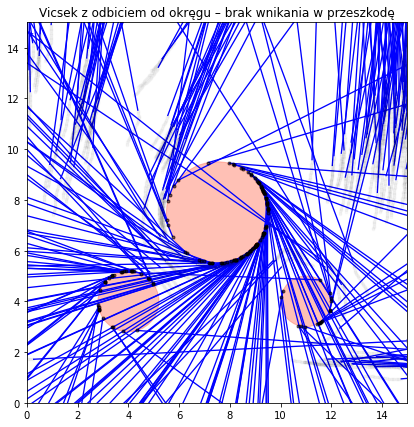

In [69]:

#


In [65]:
def plot_fig1_scenarios():
    """
    Odtwarza scenariusze z Rys. 1 w artykule, gdzie:
      (a) t=0, L=7, eta=2.0
      (b) L=25, eta=0.1
      (c) L=7, eta=2.0 (po pewnym czasie)
      (d) L=5, eta=0.1 (wysoka gęstość, mały szum -> stan uporządkowany)
      
    Przyjmujemy N=300, v=0.03 w każdym przypadku.
    """
    # Parametry wspólne
    N = 300
    v = 0.03
    r = 1.0
    steps = 300  # liczba kroków (można zwiększyć, by efekt był silniejszy)
    
    # Konfiguracje (a), (b), (c), (d)
    configs = [
        dict(L=7,  eta=2.0, desc="(a) L=7, eta=2.0, t=0"),
        dict(L=25, eta=0.1, desc="(b) L=25, eta=0.1"),
        dict(L=7,  eta=2.0, desc="(c) L=7, eta=2.0"),
        dict(L=5,  eta=0.1, desc="(d) L=5, eta=0.1"),
    ]
    
    fig, axes = plt.subplots(2,2,figsize=(10,10))
    axes = axes.ravel()
    
    for i, cfg in enumerate(configs):
        # Uruchamiamy symulację
        # Uwaga: dla (a) chcemy widzieć TYLKO stan początkowy (t=0),
        #        w pozostałych - stan "po czasie".
        if i == 0:
            # "t=0" -> odpalamy, ale narysujemy tylko początek.
            all_pos, all_head = vicsek_simulation_ckdtree_vectorized(
                N=N, L=cfg['L'], r=r, eta=cfg['eta'], v=v, steps=1
            )
            step_to_plot = 0  # początek
        else:
            # (b), (c), (d) -> czekamy do końca
            all_pos, all_head = vicsek_simulation_ckdtree_vectorized(
                N=N, L=cfg['L'], r=r, eta=cfg['eta'], v=v, steps=steps
            )
            step_to_plot = -1  # ostatnia klatka
        
        ax = axes[i]
        
        # Ostatnie 20 kroków trajektorii (lub odpowiednio mniej, jeśli symulacja krótka)
        last_n = 20
        t_min = max(0, len(all_pos)-last_n)
        for t in range(t_min, len(all_pos)):
            pos_t = all_pos[t]
            ax.plot(pos_t[:,0], pos_t[:,1], 'k.', alpha=0.02)  # kropki trajektorii
        
        # Rysujemy strzałki
        pos_final = all_pos[step_to_plot]
        head_final = all_head[step_to_plot]
        ax.quiver(
            pos_final[:,0], pos_final[:,1],
            np.cos(head_final), np.sin(head_final),
            angles='xy', scale_units='xy', scale=1.0, color='blue'
        )
        
        ax.set_xlim([0, cfg['L']])
        ax.set_ylim([0, cfg['L']])
        ax.set_aspect('equal', 'box')
        ax.set_title(cfg['desc'])
    
    plt.suptitle("Rys. 1 – przykładowa wizualizacja modelu Vicseka (N=300, v=0.03)")
    plt.tight_layout()
    plt.show()

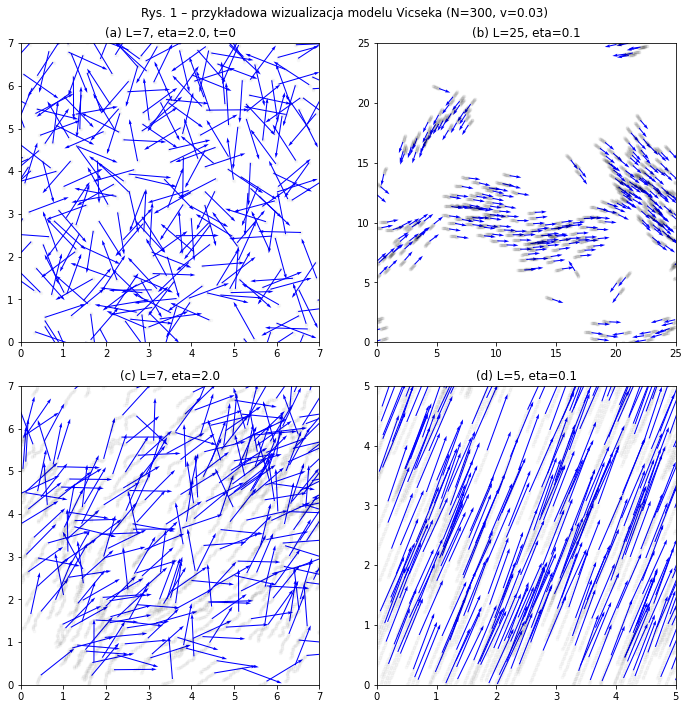

In [66]:
plot_fig1_scenarios()

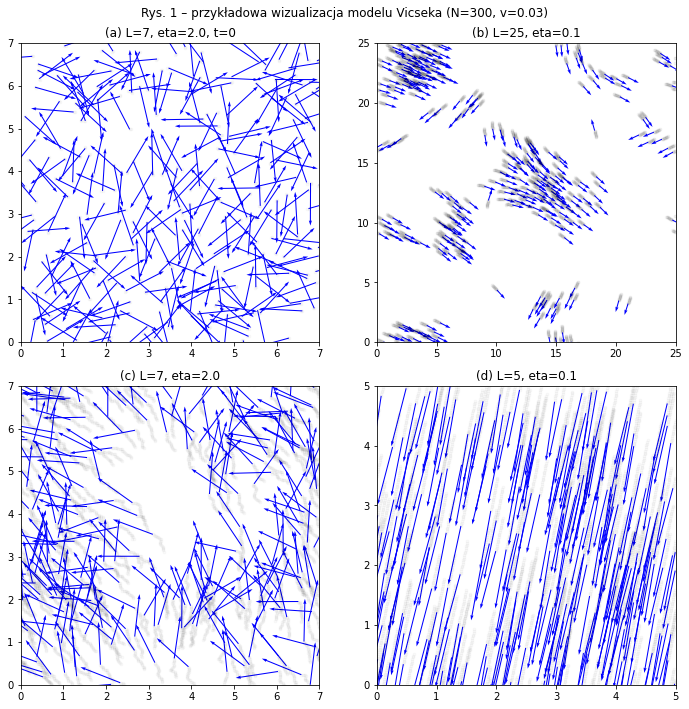

In [16]:
plot_fig1_scenarios()

---

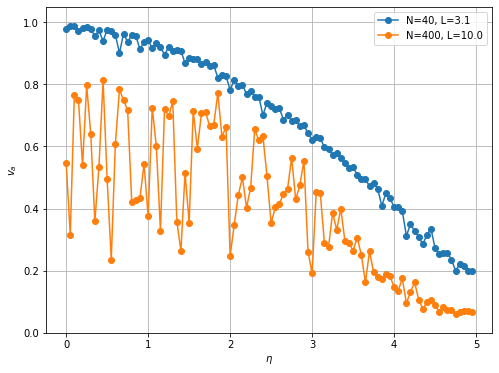

In [12]:
plot_fig2()